[*********************100%%**********************]  1 of 1 completed


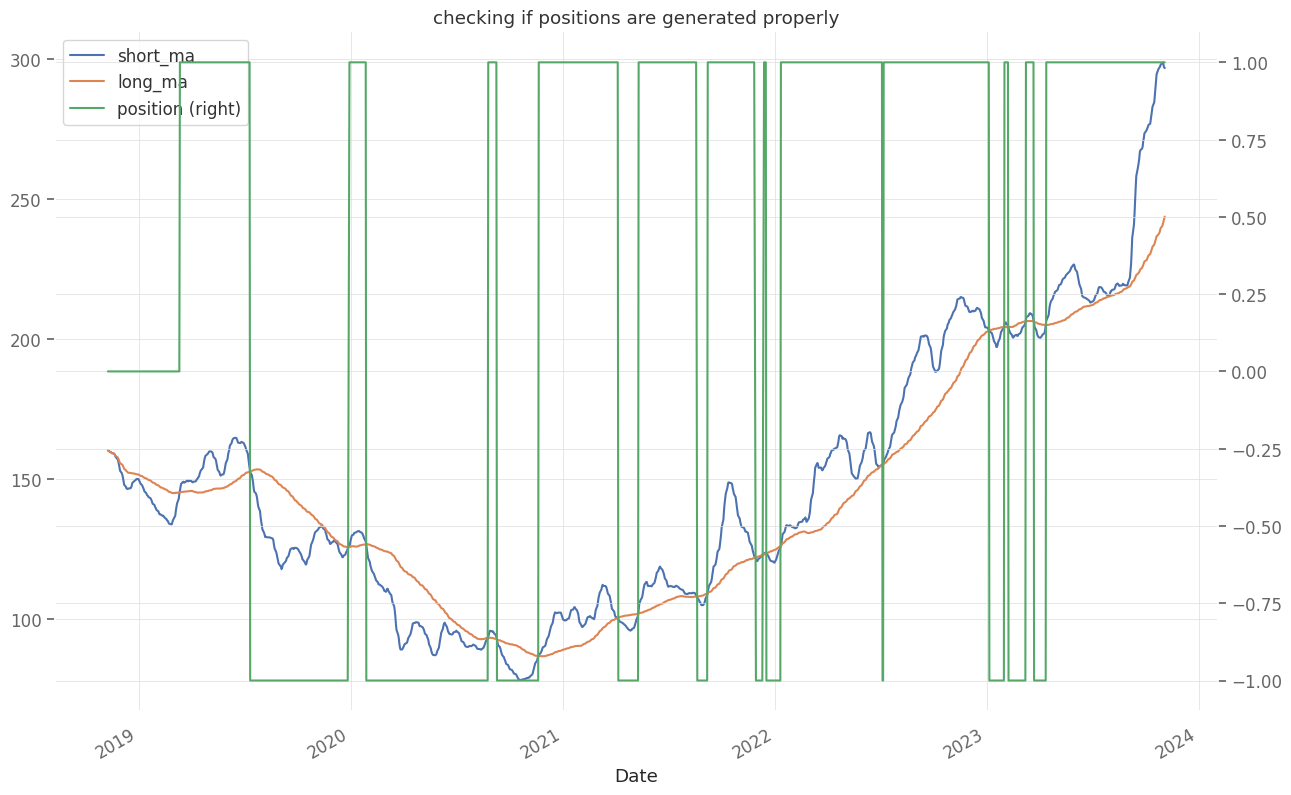

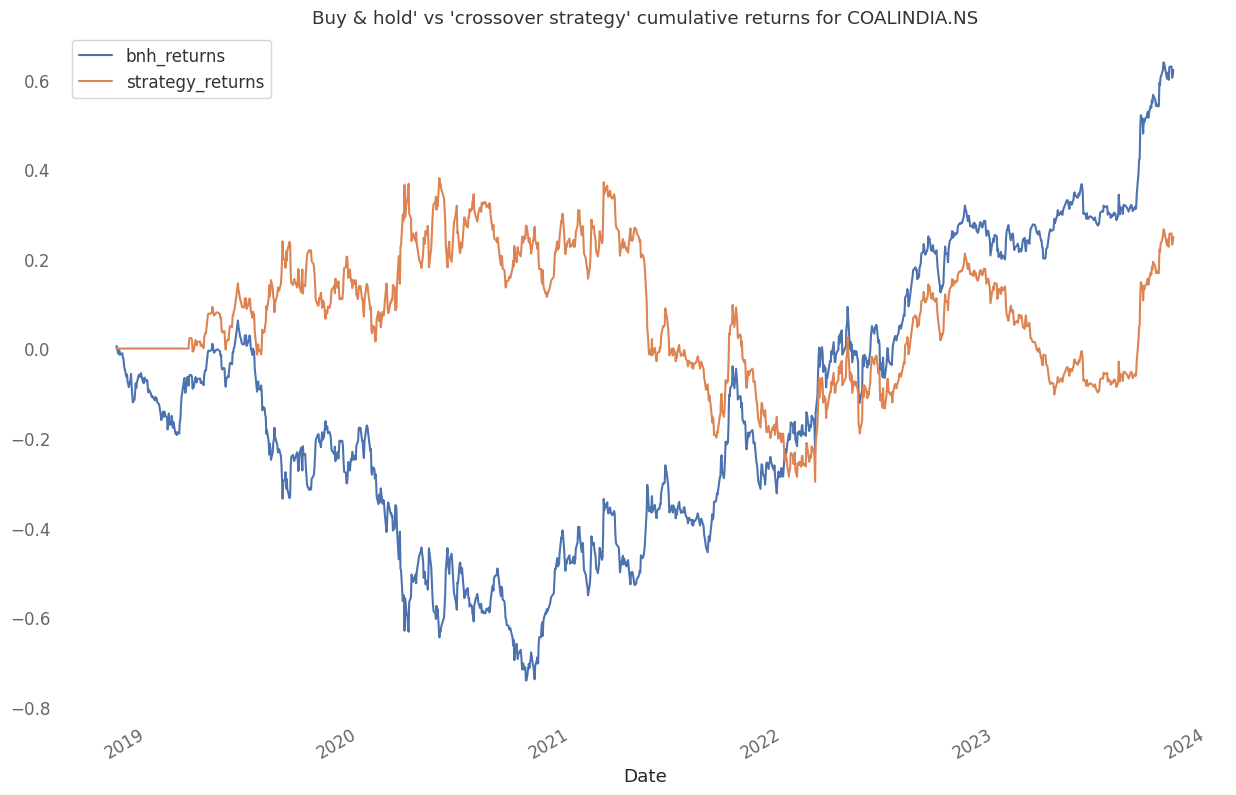

                    Strategy
------------------  ----------
Start Period        2018-11-09
End Period          2023-11-03
Risk-Free Rate      0.0%
Time in Market      93.0%

Cumulative Return   1.49%
CAGR﹪              0.21%

Sharpe              0.16
Prob. Sharpe Ratio  64.19%
Sortino             0.24
Sortino/√2          0.17
Omega               1.03

Max Drawdown        -53.7%
Longest DD Days     1324

Gain/Pain Ratio     0.03
Gain/Pain (1M)      0.14

Payoff Ratio        1.07
Profit Factor       1.03
Common Sense Ratio  1.05
CPC Index           0.54
Tail Ratio          1.02
Outlier Win Ratio   4.03
Outlier Loss Ratio  3.83

MTD                 -0.75%
3M                  33.98%
6M                  32.5%
YTD                 8.58%
1Y                  5.51%
3Y (ann.)           -1.68%
5Y (ann.)           0.21%
10Y (ann.)          0.21%
All-time (ann.)     0.21%

Avg. Drawdown       -12.36%
Avg. Drawdown Days  185
Recovery Factor     0.46
Ulcer Index         0.3
Serenity Index      0.03


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


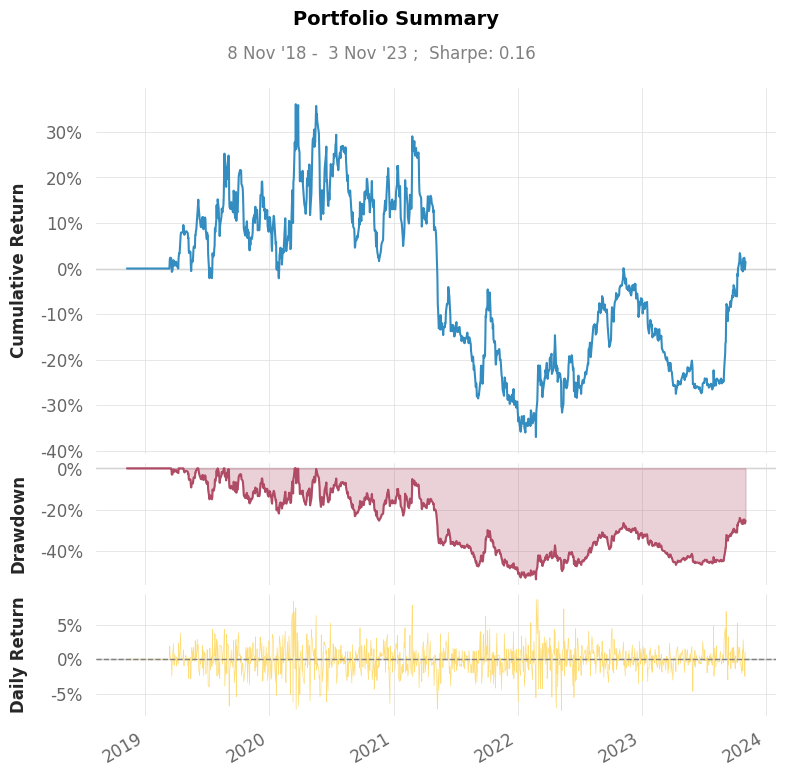

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


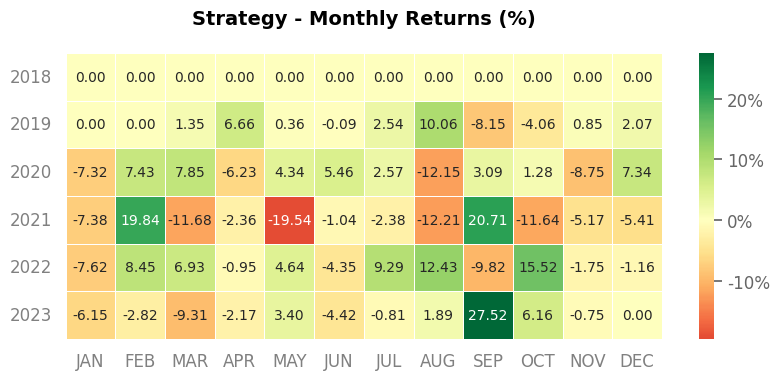

Start date,2018-11-09
End date,2023-11-03
Total months,58
,Backtest
Annual return,0.3%
Cumulative returns,1.5%
Annual volatility,31.0%
Sharpe ratio,0.16
Calmar ratio,0.01
Stability,0.43
Max drawdown,-53.7%


     stock_name  long_ma  short_ma  net_returns
0  COALINDIA.NS       10       100     0.249051


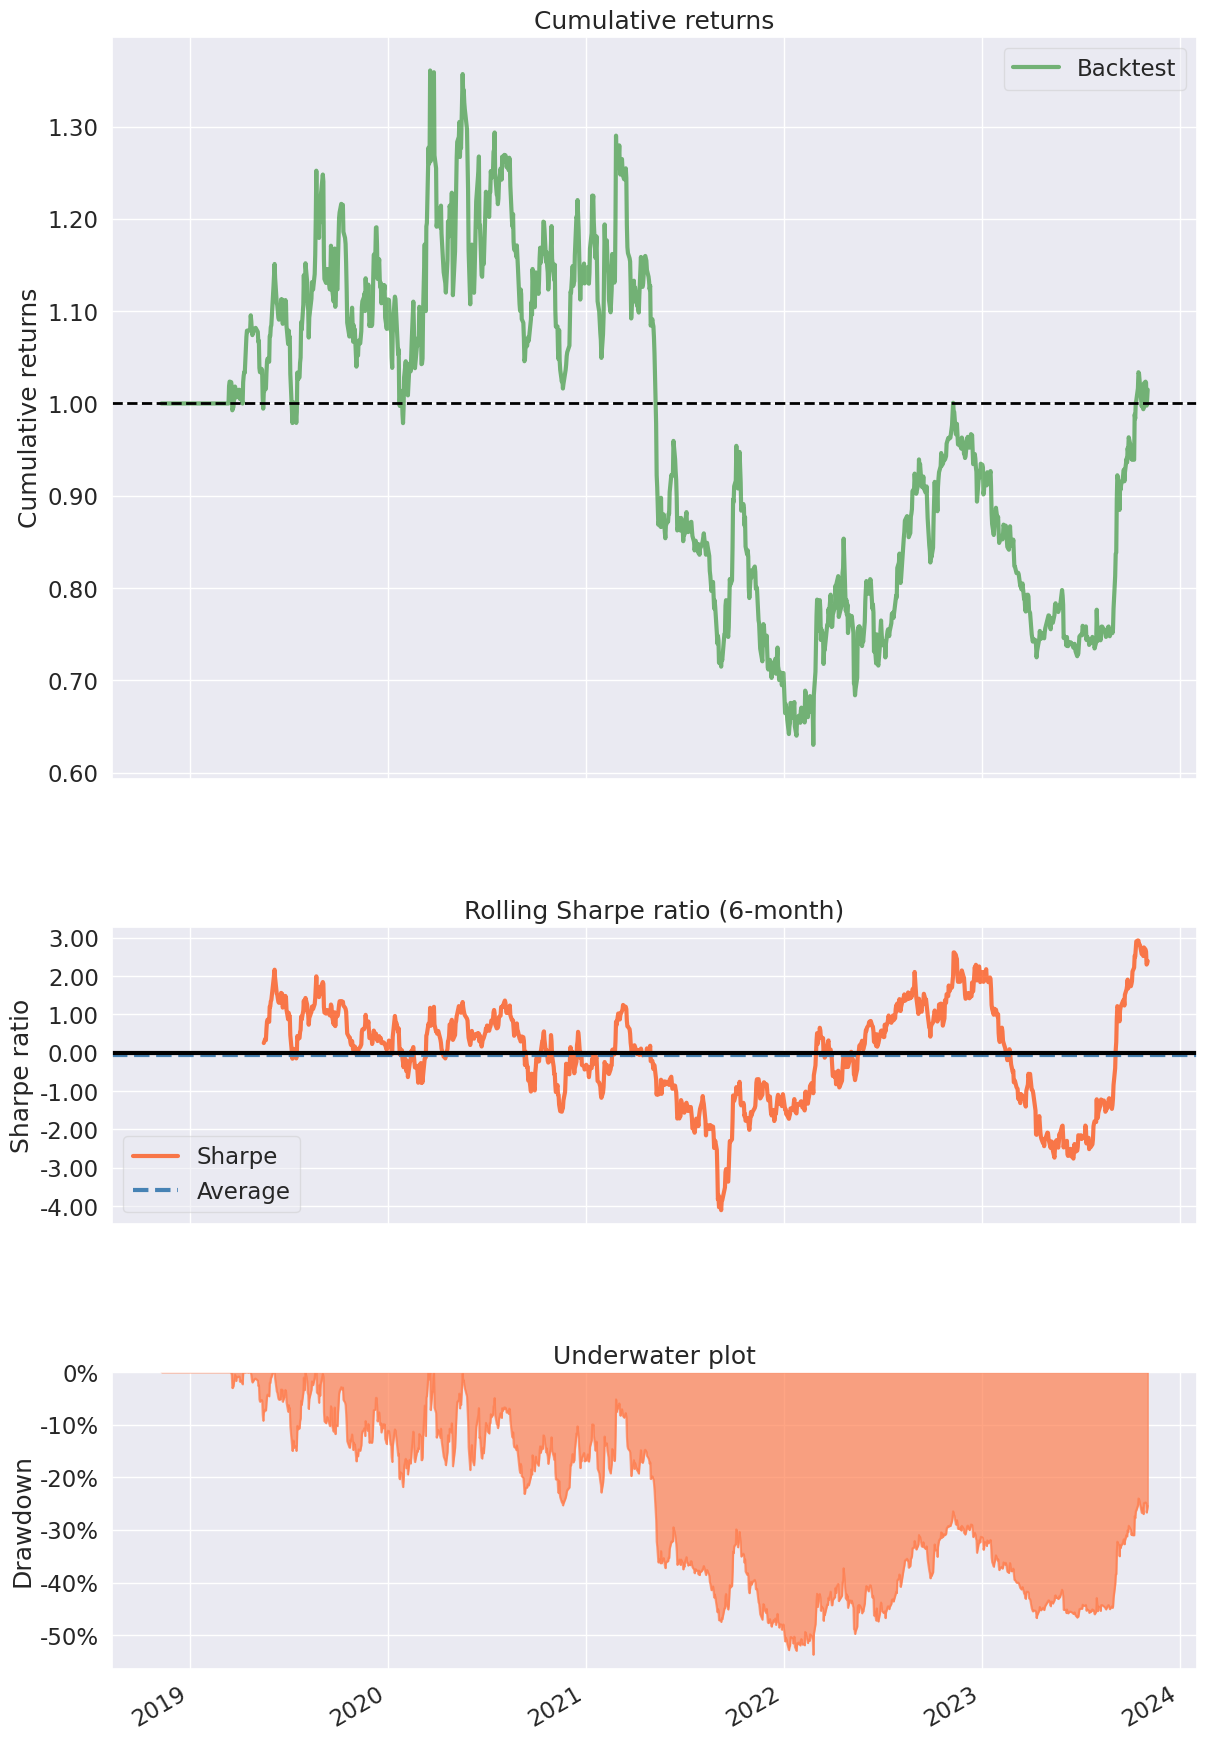

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime as dt

import pyfolio as pf 
import quantstats as qs



class Backtest_LongShort_SMA_Crossover_Strategy:
    def __init__(self,ticker,start_date,end_date,short_ma,long_ma):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.short_ma = short_ma
        self.long_ma = long_ma
        
        # Automatically executes the function upon object creation
        self.fetch_data()
        self.indicators()
        self.signals()
        self.positions()
        self.returns()
    
    def fetch_data(self):
        self.df = yf.download(self.ticker,self.start_date,self.end_date)
        #print(self.df.head(50))
        
    def indicators(self):
        self.df['short_ma'] = self.df['Adj Close'].rolling(window = self.short_ma,min_periods = 1,center = False).mean()
        self.df['long_ma'] = self.df['Adj Close'].rolling(window = self.long_ma,min_periods = 1,center = False).mean()
        self.df['previous_short_ma'] = self.df['short_ma'].shift()
        self.df['previous_long_ma'] = self.df['long_ma'].shift()
        #self.df.dropna(inplace = True)
        
    def signals(self):
        self.df['signal'] = np.where((self.df['short_ma'] > self.df['long_ma']) & (self.df['previous_short_ma'] < self.df['previous_long_ma']),1,0)
        self.df['signal'] = np.where((self.df['short_ma'] < self.df['long_ma']) & (self.df['previous_short_ma'] > self.df['previous_long_ma']),-1,self.df['signal'])
        
    def positions(self):
        self.df['position'] = self.df['signal'].replace(to_replace = 0,method = 'ffill')
        
    def returns(self):
        self.df['bnh_returns'] = np.log(self.df['Adj Close']/self.df['Adj Close'].shift(1))
        self.df['strategy_returns'] = self.df['bnh_returns'] * self.df['position'].shift(1)
        self.df.dropna(inplace = True)
        #print("Total_returns:",np.round(self.df['strategy_returns'].cumsum()[-1]),2)
        return self.df['strategy_returns'].cumsum()[-1]
    
    def analysis(self,asset,short,long):
        self.df[['short_ma','long_ma','position']].plot(grid = True,secondary_y = 'position',figsize = (15,10))
        plt.title('checking if positions are generated properly')
        #plt.savefig("mygraph1.png")
        file_name = f"{asset}_{short}_{long}"
        folder_name = asset
        self.df[['bnh_returns','strategy_returns']].cumsum().plot(figsize = (15,10),secondary_y = 'position')
        plt.title(f"Buy & hold' vs 'crossover strategy' cumulative returns for {asset}")
        
        plt.savefig(f"/home/deepa/Trading_strategies/Moving Average Crossover Strategy/Report/{file_name}.png")
        plt.show()
        qs.reports.basic(self.df['strategy_returns'])
        pf.create_simple_tear_sheet(self.df['strategy_returns'])
        
    def sort_returns(stock_list,short_ma_list,long_ma_list):
        end_date = dt.datetime(2023,11,5).date()
        start_date =end_date - dt.timedelta(days = 365*5)
        long_ma = []
        short_ma = []
        net_returns = []
        stock_names = []
        file_name = 'Indian_Instruments_Returns.xlsx'
        
        for stock in stock_list:
            for i in short_ma_list:
                for j in long_ma_list:
                    #print(f"For {i}-{j} time periods")
                    a = Backtest_LongShort_SMA_Crossover_Strategy(stock,start_date,end_date,i,j)
                    
                    long_ma.append(i)
                    short_ma.append(j)
                    net_returns.append(a.returns())
                    stock_names.append(stock)
                    a.analysis(a.ticker,i,j)
        results = pd.DataFrame({'stock_name':stock_names,'long_ma':long_ma,'short_ma':short_ma,'net_returns':net_returns})
        results = results.sort_values(by='net_returns',ascending=False)
        results.to_excel(file_name)
        print(results)
                        
class Backtest_LongShort_EMA_Crossover_Strategy(Backtest_LongShort_SMA_Crossover_Strategy):
    def indicators(self):
        self.short_ma = self.df['Adj Close'].ewm(span = self.short_ma,adjust=False).mean()
        self.long_ma = self.df['Adj Close'].ewm(span=self.long_ma,adjust=False).mean()
        self.df['previous_short_ma'] = self.df['short_ma'].shift()
        self.df['previous_long_ma'] = self.df['long_ma'].shift()
        self.df.dropna(inplace=True)
        
                       
        
    # main function
def main():
    
    # end_date = dt.datetime(2023,11,5).date()
    # start_date =end_date - dt.timedelta(days = 365*5)
    # nifty_10_20 = Backtest_LongShort_SMA_Crossover_Strategy('^NSEI',start_date,end_date,10,20)
    # nifty_5_20 = Backtest_LongShort_SMA_Crossover_Strategy('^NSEI',start_date,end_date,5,20)
    # nifty_5_10 = Backtest_LongShort_SMA_Crossover_Strategy('^NSEI',start_date,end_date,5,10)
    # nifty_5_50 = Backtest_LongShort_SMA_Crossover_Strategy('^NSEI',start_date,end_date,5,50)
    # nifty_10_50 = Backtest_LongShort_SMA_Crossover_Strategy('^NSEI',start_date,end_date,10,50)
    
    # nifty_10_20.analysis()
    # nifty_5_20.analysis()
    # nifty_5_10.analysis()
    # nifty_5_50.analysis()
    # nifty_10_50.analysis()
    
    # Define a list of assets
    stock_list = [  #'BAJFINANCE.NS',
                    # 'TRENT.NS',
                    # 'BPCL.NS'
                    # 'BRITANNIA.NS',
                     'COALINDIA.NS'
                    # 'DRREDDY.NS',
                    # 'GAIL.NS',
                    #'ASIANPAINT.NS',
                    # 'ASHOKLEY.NS',
                    #'L&TFH.NS',
                    # 'TCS.NS',
                    # 'LUPIN.NS',
                    # 'CUMMINSIND.NS',
                    #'COFORGE.NS'                   
                ]
    short_ma_list = [10]
    long_ma_list = [100]
    #Backtest_LongShort_SMA_Crossover_Strategy.sort_returns(stock_list,short_ma_list,long_ma_list)
    Backtest_LongShort_EMA_Crossover_Strategy.sort_returns(stock_list,short_ma_list,long_ma_list)

        
if __name__ == '__main__':
    main()
        
        
        
    
        
        
    
        

        
    